In [4]:
import warnings
import pandas as pd
import arviz as az

import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
from libs.model import HGPforecaster
from libs.metrics import calculate_metrics, metrics_to_table
from libs.pre_processing import generate_groups_data
from libs.visual_analysis import visualize_fit, visualize_predict
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt
import seaborn as sns
import numpy as np
az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore')

covid19 = pd.read_csv('../data/owid-covid-data.csv')

# remove world
covid19 = covid19.loc[covid19['iso_code'] != 'OWID_WRL']

# Just the basic groups

covid = covid19[['location', 'continent', 'date', 'new_cases']] 
covid.columns = ['Country', 'Continent', 'Date', 'Count']
covid['Date'] = covid['Date'].astype('datetime64[ns]')

covid.groupby(['Date', 'Country']).sum().sort_values(by=['Count'], ascending=False).iloc[0,:]

# Turkey has a very strange value - removing

covid = covid.loc[covid['Country'] != 'Turkey']
covid = covid.set_index('Date')

covid_pivot = covid.reset_index().pivot(index='Date',columns=['Continent', 'Country'], values='Count')
covid_pivot = covid_pivot.fillna(0)

groups_input = {
    'Continent': [0],
    'Country': [1],
}

groups = generate_groups_data(covid_pivot, groups_input, seasonality=7, h=30)

Number of groups: 2
	Continent: 7
	Country: 190
Total number of series: 190
Number of points per series for train: 334
Total number of points: 364
Seasonality: 7
Forecast horizon: 30


In [3]:
X = np.arange(groups['train']['n']).reshape(-1,1)
X_new = np.arange(groups['predict']['n']).reshape(-1,1)

p_s_fit = []
p_s_predict = []

for i in range(groups['train']['s']):
    try:
        with pm.Model() as model:

            period = pm.Gamma('period', 70, 10)


            l_t = pm.Gamma('l_t', 5, 1, testval=0.5)
            l_p = pm.Gamma('l_p', 2, 1, testval=0.5)
            η_trend = pm.HalfNormal('η_trend',0.15, testval=0.5)#, testval=0.15)
            η_per = pm.HalfNormal('η_per',0.5, testval=0.5)
            σ  = pm.HalfNormal("σ",  sigma=0.1, testval=0.05)

            a = pm.Normal('a', np.log(np.mean(groups['train']['data'].reshape(groups['train']['s'], groups['train']['n']).T[:,i])),0.1) 
            b = pm.Normal('b', mu=0, sd=0.1, testval=0.1)

            mu_func = pm.gp.mean.Linear(intercept = a,
                                       coeffs = b)


            # cov function for the GP 
            cov = (η_trend * pm.gp.cov.ExpQuad(input_dim=1, ls=l_t)
                    + η_per * pm.gp.cov.Periodic(1, period=period, ls=l_p) 
                    + pm.gp.cov.WhiteNoise(σ))

            gp = pm.gp.Latent(mean_func=mu_func, cov_func=cov)
            f = gp.prior('f', X=X, reparameterize=True)

            y_pred = pm.Poisson('y_pred', mu=tt.exp(f), observed=groups['train']['data'].reshape(groups['train']['s'], groups['train']['n']).T[:,i])
            mp = pm.find_MAP(maxeval=5000, progressbar = False)
        
    except Exception as e:
        print(e)
        series_not_run.append(i)
            
            
    with model:
        pred_samples_fit = pm.sample_posterior_predictive([mp], 
                                      vars=[y_pred], 
                                      samples=200,
                                      progressbar=False)

        f_n = gp.conditional('f_n', Xnew=X_new)

        y_pred_new = pm.Poisson("y_pred_new", 
                                mu=tt.exp(f_n), 
                                shape=X_new.shape[0])

        pred_samples_predict = pm.sample_posterior_predictive([mp], 
                                                  vars=[y_pred_new], 
                                                  samples=200,
                                                  progressbar = False)

    print(str(i)+'/'+str(groups['train']['s']-1))
    p_s_fit.append(pred_samples_fit['y_pred'])
    p_s_predict.append(pred_samples_predict['y_pred_new'])
    series_run.append(i)

NameError: name 'np' is not defined

In [ ]:
p_s_fit = np.asarray(p_s_fit)
p_s_predict = np.asarray(p_s_predict)
p_s_fit = p_s_fit.transpose(1, 0, 2).reshape(200, groups['train']['n']*groups['train']['s'])
p_s_predict = p_s_predict.transpose(1, 0, 2).reshape(200, groups['predict']['n']*groups['predict']['s'])
p_s_fit_d = {}
p_s_predict_d = {}
p_s_fit_d['y_pred'] = p_s_fit
p_s_predict_d['y_pred_new'] = p_s_predict

visualize_fit(groups, p_s_fit_d, 8)

visualize_predict(groups, p_s_predict_d, 8)

results = calculate_metrics(p_s_predict_d, groups)
metrics_to_table(groups, results)

# Test one series

In [5]:
import matplotlib.pyplot as plt
import numpy as np

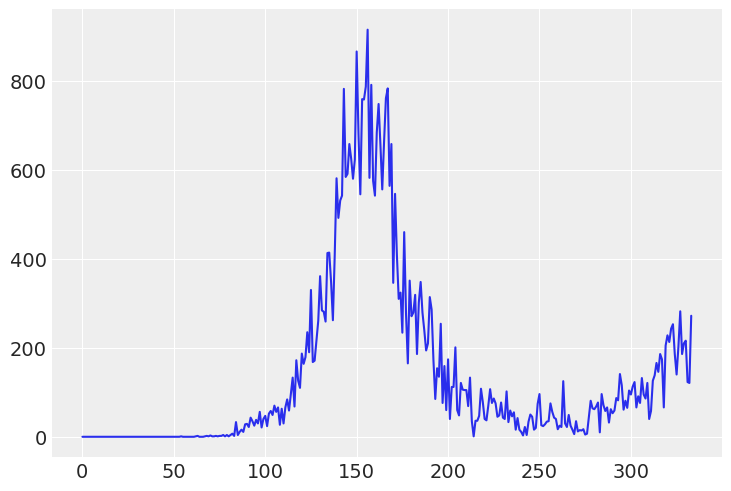

In [6]:
series = 0
X = np.arange(groups['train']['n']).reshape(-1,1)
X_new = np.arange(groups['predict']['n']).reshape(-1,1)

plt.plot(groups['train']['data'].reshape(groups['train']['s'], groups['train']['n']).T[:,series]);

In [7]:
with pm.Model() as model:

    l_t = pm.InverseGamma('l_t', 4, groups['train']['n'])
    l_p = pm.InverseGamma('l_p', 4, groups['train']['n'])
    η_trend = pm.HalfNormal('η_trend', 0.5)
    η_per = pm.HalfNormal('η_per', 1)
    σ  = pm.HalfNormal("σ",  sigma=0.01)
    
    a = pm.Normal('a', 
                  0.0,
                  5)
    b = pm.Normal('b', mu=0, sd=0.1)

    mu_func = pm.gp.mean.Linear(intercept = a,
                               coeffs = b)

    # cov function for the GP 
    cov = (η_trend**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=l_t)
            + η_per**2 * pm.gp.cov.Periodic(1, period=7, ls=l_p)
            + pm.gp.cov.WhiteNoise(σ))

    gp = pm.gp.Latent(mean_func=mu_func, cov_func=cov)
    f = gp.prior('f', X=X, reparameterize=True)

    y_pred = pm.Poisson('y_pred', mu=tt.exp(f), observed=groups['train']['data'].reshape(groups['train']['s'], groups['train']['n']).T[:,series])
    #prior_checks = pm.sample_prior_predictive(200)
    mp = pm.find_MAP(maxeval=5000, progressbar = True)

In [8]:
with pm.Model() as model:
    f_n = gp.conditional('f_n', Xnew=X_new)

    y_pred_new = pm.Poisson("y_pred_new", 
                            mu=tt.exp(f_n), 
                            shape=X_new.shape[0])

    pred_samples = pm.sample_posterior_predictive([mp], 
                                              vars=[y_pred_new], 
                                              samples=200,
                                              progressbar = False)

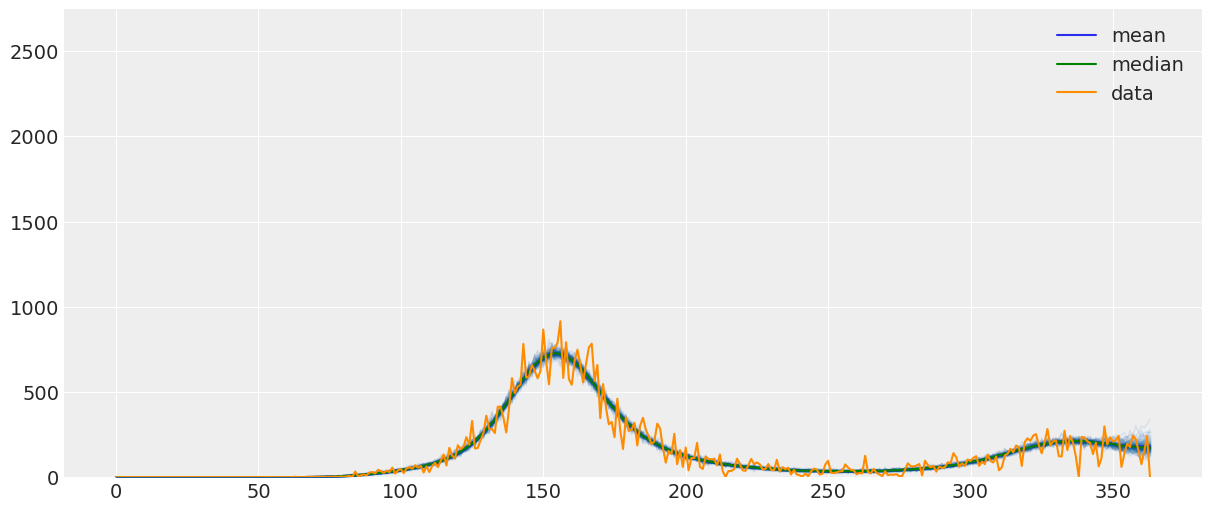

In [9]:
from pymc3.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, pred_samples['y_pred_new'], X_new, palette="Blues", fill_alpha=0.1, samples_alpha=0.1);
plt.plot(np.mean(pred_samples['y_pred_new'], axis=0), label='mean')
plt.plot(np.median(pred_samples['y_pred_new'], axis=0), label='median', color='green')
plt.plot(np.arange(groups['predict']['n']),groups['predict']['data'].reshape(groups['predict']['s'], groups['predict']['n']).T[:,series], label='data', color='darkorange')
plt.ylim(0,max(groups['train']['data'].reshape(groups['train']['s'], groups['train']['n']).T[:,series])*3)
plt.legend();